In [1]:
# ============================================================
# BLOCK A
# Setup, safe Drive mount, data load, label mapping, class weights
# ============================================================

%pip install -q optuna joblib shap

import os, sys, time, json, random
import numpy as np
from pathlib import Path
import joblib
import platform

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ---------------------------
# Safe Drive mount
# ---------------------------
from google.colab import drive

if not os.path.isdir("/content/drive"):
    os.makedirs("/content/drive", exist_ok=True)

try:
    drive.mount('/content/drive')
except Exception:
    # if already mounted or busy, continue
    print("Drive mount attempted; if already mounted this is fine.")

# ---------------------------
# Paths & outputs
# ---------------------------
BASE = "/content/drive/MyDrive/InfoSec_Dataset"
X_train_fname = "X_train_preprocessed.npy"
y_train_fname = "y_train_preprocessed.npy"
X_test_fname  = "X_test_preprocessed.npy"
y_test_fname  = "y_test_preprocessed.npy"

OUT_DIR = os.path.join(BASE, "model_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Load arrays (safe)
# ---------------------------
def assert_and_load(base, fname):
    path = os.path.join(base, fname)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Required file not found: {path}")
    arr = np.load(path, allow_pickle=True)
    return arr, path

print("Loading arrays from:", BASE)
X_train_full, p_X_train = assert_and_load(BASE, X_train_fname)
y_train_full, p_y_train = assert_and_load(BASE, y_train_fname)
X_test,        p_X_test  = assert_and_load(BASE, X_test_fname)
y_test,        p_y_test  = assert_and_load(BASE, y_test_fname)

print("Loaded:")
print(" - X_train_full:", p_X_train, "shape:", X_train_full.shape, "dtype:", X_train_full.dtype)
print(" - y_train_full:", p_y_train, "shape:", y_train_full.shape, "dtype:", np.array(y_train_full).dtype)
print(" - X_test:", p_X_test, "shape:", X_test.shape, "dtype:", X_test.dtype)
print(" - y_test:", p_y_test, "shape:", y_test.shape, "dtype:", np.array(y_test).dtype)

# ---------------------------
# Ensure correct dtypes
# ---------------------------
X_train_full = X_train_full.astype('float32')
X_test       = X_test.astype('float32')
y_train_full = np.array(y_train_full)
y_test       = np.array(y_test)

# ---------------------------
# Map original labels (including 99) -> contiguous 0..C-1
# ---------------------------
print("\nMapping labels to contiguous indices (0..C-1).")
all_labels = np.unique(np.concatenate([y_train_full, y_test]))
all_labels_sorted = np.sort(all_labels)
label_to_idx = {lab: int(i) for i, lab in enumerate(all_labels_sorted)}
idx_to_label = {int(i): lab for lab, i in label_to_idx.items()}

# Apply mapping
y_train_mapped = np.vectorize(label_to_idx.get)(y_train_full)
y_test_mapped  = np.vectorize(label_to_idx.get)(y_test)

# Replace variables used downstream
y_train_full = y_train_mapped
y_test = y_test_mapped

num_classes = len(label_to_idx)
print("Original labels:", all_labels_sorted)
print("Num mapped classes:", num_classes)
print("Mapping saved (first 10):", list(label_to_idx.items())[:10])

# Save mapping for future use
joblib.dump({'label_to_idx': label_to_idx, 'idx_to_label': idx_to_label},
            os.path.join(OUT_DIR, "label_mapping.joblib"))

# ---------------------------
# Create stratified train/validation split (guarantees classes)
# Use X_train_full & y_train_full as loaded; keep X_test untouched
# ---------------------------
from sklearn.model_selection import train_test_split

print("\nCreating stratified split for train/validation.")
# 85% train, 15% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

# split temp into validation (50% of temp -> 7.5% of original)
X_val, X_discard, y_val, y_discard = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("Shapes after split:")
print(" - X_train:", X_train.shape, "y_train:", y_train.shape)
print(" - X_val  :", X_val.shape,   "y_val:",   y_val.shape)
print(" - X_test :", X_test.shape,   "y_test:",  y_test.shape)

# Quick class counts to inspect rarity
def class_counts(arr, name):
    unique, counts = np.unique(arr, return_counts=True)
    print(f"\nClass distribution for {name}:")
    for u,c in zip(unique, counts):
        print(f"  class {u}: {c:,} samples")
class_counts(y_train_full, "TRAIN_FULL (mapped)")
class_counts(y_train, "TRAIN (mapped)")
class_counts(y_val, "VAL (mapped)")
class_counts(y_test, "TEST (mapped)")

# ---------------------------
# Compute class weights (balanced)
# ---------------------------
from sklearn.utils.class_weight import compute_class_weight
classes = np.arange(num_classes)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, cw)}
print("\nClass weight dict (sample):", list(class_weight_dict.items())[:10])
joblib.dump(class_weight_dict, os.path.join(OUT_DIR, "class_weight_dict.joblib"))

# ---------------------------
# TensorFlow GPU config (if present)
# ---------------------------
TF_AVAILABLE = False
try:
    import tensorflow as tf
    TF_AVAILABLE = True
    tf.random.set_seed(RANDOM_STATE)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("\nTensorFlow detected GPU(s). Enabling memory growth.")
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        DEVICE_INFO = "GPU"
    else:
        print("\nNo TensorFlow GPU detected; using CPU.")
        DEVICE_INFO = "CPU"
except Exception as e:
    print("\nTensorFlow import failed or not present:", e)
    DEVICE_INFO = "CPU"

# Save a manifest
manifest = {
    "base_path": BASE,
    "train_shape": X_train.shape,
    "val_shape": X_val.shape,
    "test_shape": X_test.shape,
    "num_classes": num_classes,
    "random_state": RANDOM_STATE,
    "device": DEVICE_INFO,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(os.path.join(OUT_DIR, "run_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)
print("\nSaved run manifest:", os.path.join(OUT_DIR, "run_manifest.json"))

print("\n=== Blocks A completed successfully. ===")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.2 MB/s eta 0:00:00
Mounted at /content/drive
Loading arrays from: /content/drive/MyDrive/InfoSec_Dataset
Loaded:
 - X_train_full: /content/drive/MyDrive/InfoSec_Dataset/X_train_preprocessed.npy shape: (2059408, 85) dtype: float32
 - y_train_full: /content/drive/MyDrive/InfoSec_Dataset/y_train_preprocessed.npy shape: (2059408,) dtype: int64
 - X_test: /content/drive/MyDrive/InfoSec_Dataset/X_test_preprocessed.npy shape: (514853, 85) dtype: float32
 - y_test: /content/drive/MyDrive/InfoSec_Dataset/y_test_preprocessed.npy shape: (514853,) dtype: int64

Mapping labels to contiguous indices (0..C-1).
Original labels: [ 0  1  2  3  4  5  6  7 10 11 12 14 99]
Num mapped classes: 13
Mapping saved (first 10): [(np.int64(0), 0), (np.int64(1), 1), (np.int64(2), 2), (np.int64(3), 3), (np.int64(4), 4), (np.int64(5), 5), (np.int64(6), 6), (np.int64(7), 7), (np.int64(10), 8), (np.int64(11), 9)]

Creating stratified split for train/validati

In [2]:
# ---------------------------
# === BLOCK B: Feature Engineering (Entropy + Scaling + PCA + subsampled mRMR)
# ---------------------------
print("\n=== BLOCK B: Entropy + Scaling + PCA + subsampled mRMR ===")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

# 1) Entropy feature (vectorized)
def compute_entropy_feature(X):
    X_abs = np.abs(X)
    row_sums = X_abs.sum(axis=1, keepdims=True) + 1e-12
    probs = X_abs / row_sums
    entropy_vals = -(probs * np.log2(probs + 1e-12)).sum(axis=1, keepdims=True)
    return entropy_vals

ent_train = compute_entropy_feature(X_train)
ent_val   = compute_entropy_feature(X_val)
ent_test  = compute_entropy_feature(X_test)

X_train_e = np.hstack([X_train, ent_train])
X_val_e   = np.hstack([X_val,   ent_val])
X_test_e  = np.hstack([X_test,  ent_test])

print("Added entropy. Shapes:", X_train_e.shape, X_val_e.shape, X_test_e.shape)

# 2) Standard scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_e)
X_val_s   = scaler.transform(X_val_e)
X_test_s  = scaler.transform(X_test_e)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))
print("Scaling complete. Saved scaler.")

# 3) PCA (95% variance)
pca = PCA(n_components=0.95, svd_solver='full', random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_s)
X_val_pca   = pca.transform(X_val_s)
X_test_pca  = pca.transform(X_test_s)
joblib.dump(pca, os.path.join(OUT_DIR, "pca_model.joblib"))
print("PCA complete. Reduced dims:", X_train_pca.shape, "Explained variance sum:", pca.explained_variance_ratio_.sum())

# 4) Subsampled MI + fast mRMR selection
def fast_mrmr_subsampled(X, y, K=30, sample_size=50000):
    n = X.shape[0]
    n_sub = int(min(sample_size, n))
    # ensure reproducibility
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(n, n_sub, replace=False)
    X_sub = X[idx]
    y_sub = y[idx]

    print(f"\nComputing mutual information on {n_sub} subsample (fast).")
    mi = mutual_info_classif(X_sub, y_sub, n_neighbors=3, random_state=RANDOM_STATE)

    top_k_candidates = min(40, X.shape[1])
    top_idx = np.argsort(mi)[::-1][:top_k_candidates]

    print("Computing correlation matrix on top MI features...")
    corr = np.corrcoef(X_sub[:, top_idx].T)

    selected = []
    redundancy_threshold = 0.90

    for f in top_idx:
        if len(selected) >= K:
            break
        if not selected:
            selected.append(int(f))
            continue
        cand_idx = top_idx.tolist().index(int(f))
        selected_mapped = [top_idx.tolist().index(s) for s in selected]
        redundancies = np.abs(corr[cand_idx, selected_mapped])
        if np.all(redundancies < redundancy_threshold):
            selected.append(int(f))

    return selected[:K]

K = min(30, X_train_s.shape[1])
selected_idx = fast_mrmr_subsampled(X_train_s, y_train, K=K, sample_size=50000)
print("Selected mRMR indices:", selected_idx)

X_train_mrmr = X_train_s[:, selected_idx]
X_val_mrmr   = X_val_s[:, selected_idx]
X_test_mrmr  = X_test_s[:, selected_idx]

with open(os.path.join(OUT_DIR, "mrmr_selected_features.txt"), "w") as f:
    f.write("\n".join(map(str, selected_idx)))
print("Saved mRMR feature indices.")

# 5) Combined features (PCA + mRMR)
X_train_combined = np.hstack([X_train_pca, X_train_mrmr])
X_val_combined   = np.hstack([X_val_pca,   X_val_mrmr])
X_test_combined  = np.hstack([X_test_pca,  X_test_mrmr])

print("\nCombined shapes (PCA + mRMR):")
print(" - X_train_combined:", X_train_combined.shape)
print(" - X_val_combined  :", X_val_combined.shape)
print(" - X_test_combined :", X_test_combined.shape)

# Save quick sanity files
np.save(os.path.join(OUT_DIR, "X_train_combined_shape.npy"), X_train_combined.shape)
np.save(os.path.join(OUT_DIR, "X_val_combined_shape.npy"), X_val_combined.shape)
np.save(os.path.join(OUT_DIR, "X_test_combined_shape.npy"), X_test_combined.shape)

print("\n=== Block B completed successfully. ===")


=== BLOCK B: Entropy + Scaling + PCA + subsampled mRMR ===
Added entropy. Shapes: (1750496, 86) (154456, 86) (514853, 86)
Scaling complete. Saved scaler.
PCA complete. Reduced dims: (1750496, 35) Explained variance sum: 0.95588434

Computing mutual information on 50000 subsample (fast).
Computing correlation matrix on top MI features...
Selected mRMR indices: [50, 40, 5, 55, 59, 10, 6, 58, 23, 20, 32, 21, 51, 14, 0, 35, 70, 34, 16, 71, 72, 73, 76]
Saved mRMR feature indices.

Combined shapes (PCA + mRMR):
 - X_train_combined: (1750496, 58)
 - X_val_combined  : (154456, 58)
 - X_test_combined : (514853, 58)

=== Block B completed successfully. ===


In [3]:
# -------------------------
# C0: Shared utilities & containers
# -------------------------
import time, os, pickle, joblib
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, mean_absolute_error,
    confusion_matrix
)
from sklearn.model_selection import StratifiedShuffleSplit

print("\n=== BLOCK C0: Utilities loaded ===")

# Evaluate metrics (robust to multiclass & missing prob columns)
def evaluate_all_metrics(y_true, y_pred, y_proba=None):
    d = {}
    if y_true.ndim == 2:
        y_true = np.argmax(y_true, axis=1)
    d["accuracy"]  = accuracy_score(y_true, y_pred)
    d["precision"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    d["recall"]    = recall_score(y_true, y_pred, average="macro", zero_division=0)
    d["f1"]        = f1_score(y_true, y_pred, average="macro", zero_division=0)
    try:
        if y_proba is not None:
            if y_proba.shape[1] == 2:
                d["roc_auc"] = roc_auc_score(y_true, y_proba[:,1])
            else:
                d["roc_auc"] = roc_auc_score(y_true, y_proba, multi_class="ovr")
        else:
            d["roc_auc"] = None
    except Exception:
        d["roc_auc"] = None

    # MSE/MAE: if y_proba provided, compute against one-hot true; else against labels
    if y_proba is not None:
        C = y_proba.shape[1]
        Y_true = np.zeros((len(y_true), C))
        for i, c in enumerate(y_true):
            if c < C:
                Y_true[i, c] = 1
        try:
            d["mse"] = mean_squared_error(Y_true, y_proba)
            d["mae"] = mean_absolute_error(Y_true, y_proba)
        except Exception:
            d["mse"], d["mae"] = None, None
    else:
        d["mse"] = mean_squared_error(y_true, y_pred)
        d["mae"] = mean_absolute_error(y_true, y_pred)

    return d

# Containers
results_classical = {}
predictions_classical = {}
probabilities_classical = {}

# Helper: get calibration subset (stratified + include tiny classes)
def get_calibration_subset(X, y, frac=0.05, min_per_class=5, random_state=RANDOM_STATE):
    n = X.shape[0]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    for _, idx in sss.split(X, y):
        Xc = X[idx]
        yc = y[idx]
    # ensure tiny classes included
    unique, counts = np.unique(y, return_counts=True)
    tiny = [u for u,c in zip(unique, counts) if c <= min_per_class]
    if tiny:
        tiny_idx = np.where(np.isin(y, tiny))[0]
        combined = np.unique(np.concatenate([idx, tiny_idx]))
        Xc = X[combined]
        yc = y[combined]
    return Xc, yc

print("C0 ready. Containers initialized.")


=== BLOCK C0: Utilities loaded ===
C0 ready. Containers initialized.


In [4]:
# -------------------------
# C1: Logistic Regression (SGD + Calibrate + Padding)
# -------------------------
print("\n=== BLOCK C1: Logistic Regression (SGD + Calibrate + Pad) ===")
try:
    from sklearn.linear_model import SGDClassifier
    from sklearn.calibration import CalibratedClassifierCV

    t0 = time.time()
    sgd = SGDClassifier(
        loss="log_loss",
        alpha=1/10.0,
        max_iter=2000,
        tol=1e-3,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    sgd.fit(X_train_s, y_train)
    t_train = time.time() - t0
    print(f"SGD trained in {t_train:.2f}s")

    # calibration subset (stratified)
    X_calib, y_calib = get_calibration_subset(X_train_s, y_train, frac=0.05, min_per_class=5)
    calibrator = CalibratedClassifierCV(sgd, method="sigmoid", cv='prefit')
    calibrator.fit(X_calib, y_calib)

    # predict & pad
    y_proba_raw = calibrator.predict_proba(X_test_s)
    y_pred = calibrator.predict(X_test_s)

    # padding to full num_classes if needed
    full_C = int(num_classes)
    raw_classes = calibrator.classes_
    C_raw = len(raw_classes)
    if C_raw != full_C:
        print(f"Padding probabilities: model has {C_raw} classes, dataset has {full_C}.")
        y_proba = np.zeros((y_proba_raw.shape[0], full_C), dtype=float)
        for i, cls in enumerate(raw_classes):
            y_proba[:, int(cls)] = y_proba_raw[:, i]
    else:
        y_proba = y_proba_raw

    metrics = evaluate_all_metrics(y_test, y_pred, y_proba)
    results_classical["LogisticRegression"] = {"test_metrics": metrics, "train_time_sec": t_train}
    predictions_classical["LogisticRegression"] = y_pred
    probabilities_classical["LogisticRegression"] = y_proba

    joblib.dump(calibrator, os.path.join(OUT_DIR, "LogisticRegression.joblib"))
    print("Saved LogisticRegression (calibrated).")
    print("LR metrics:", metrics)

except Exception as e:
    print("Error in LogisticRegression block:", e)


=== BLOCK C1: Logistic Regression (SGD + Calibrate + Pad) ===
SGD trained in 80.39s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Saved LogisticRegression (calibrated).
LR metrics: {'accuracy': 0.9198314858804357, 'precision': 0.40525841108594385, 'recall': 0.20495822417446494, 'f1': 0.22834200297564125, 'roc_auc': np.float64(0.9008729825707132), 'mse': 0.009078460236545117, 'mae': 0.018546774386015093}


In [5]:
# -------------------------
# C2: Decision Tree
# -------------------------
print("\n=== BLOCK C2: DecisionTree ===")
try:
    from sklearn.tree import DecisionTreeClassifier
    t0 = time.time()
    dt = DecisionTreeClassifier(class_weight=class_weight_dict, random_state=RANDOM_STATE)
    dt.fit(X_train_s, y_train)
    t_train = time.time() - t0

    y_pred = dt.predict(X_test_s)
    try:
        y_proba = dt.predict_proba(X_test_s)
    except Exception:
        # fallback to one-hot
        y_proba = np.zeros((len(y_pred), num_classes))
        for i,p in enumerate(y_pred):
            y_proba[i, p] = 1.0

    metrics = evaluate_all_metrics(y_test, y_pred, y_proba)
    results_classical["DecisionTree"] = {"test_metrics": metrics, "train_time_sec": t_train}
    predictions_classical["DecisionTree"] = y_pred
    probabilities_classical["DecisionTree"] = y_proba

    joblib.dump(dt, os.path.join(OUT_DIR, "DecisionTree.joblib"))
    print("Saved DecisionTree. Metrics:", metrics)

except Exception as e:
    print("Error in DecisionTree block:", e)


=== BLOCK C2: DecisionTree ===
Saved DecisionTree. Metrics: {'accuracy': 0.9983218510914766, 'precision': 0.9065272793446236, 'recall': 0.9060038364470184, 'f1': 0.9057907029828564, 'roc_auc': np.float64(0.9527889099658642), 'mse': 0.00025817675515744676, 'mae': 0.00025817675515744676}


In [6]:
# -------------------------
# C3: Random Forest
# -------------------------
print("\n=== BLOCK C3: RandomForest (safe) ===")
try:
    from sklearn.ensemble import RandomForestClassifier
    t0 = time.time()
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=None,
        max_samples=0.2,       # train each tree on 20% of data -> reduces memory/time
        class_weight=class_weight_dict,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )
    rf.fit(X_train_s, y_train)
    t_train = time.time() - t0

    y_pred = rf.predict(X_test_s)
    y_proba = rf.predict_proba(X_test_s)

    metrics = evaluate_all_metrics(y_test, y_pred, y_proba)
    results_classical["RandomForest"] = {"test_metrics": metrics, "train_time_sec": t_train}
    predictions_classical["RandomForest"] = y_pred
    probabilities_classical["RandomForest"] = y_proba

    joblib.dump(rf, os.path.join(OUT_DIR, "RandomForest.joblib"))
    print("Saved RandomForest. Metrics:", metrics)

except Exception as e:
    print("Error in RandomForest block:", e)


=== BLOCK C3: RandomForest (safe) ===
Saved RandomForest. Metrics: {'accuracy': 0.9983471010171835, 'precision': 0.9382182513151893, 'recall': 0.797233046192133, 'f1': 0.8266342694119708, 'roc_auc': np.float64(0.9888780209565329), 'mse': 0.00019532529748224307, 'mae': 0.0005303380845525425}


In [10]:
# -------------------------
# C4: HistGradientBoosting (use sample_weight)
# -------------------------
print("\n=== BLOCK C4: HistGradientBoosting ===")
try:
    from sklearn.ensemble import HistGradientBoostingClassifier
    # sample weights from class weight dict
    sample_weight = np.array([class_weight_dict[int(y)] for y in y_train])
    t0 = time.time()
    hgb = HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
    hgb.fit(X_train_s, y_train, sample_weight=sample_weight)
    t_train = time.time() - t0

    y_pred = hgb.predict(X_test_s)
    try:
        y_proba = hgb.predict_proba(X_test_s)
    except Exception:
        y_proba = np.zeros((len(y_pred), num_classes))
        for i,p in enumerate(y_pred):
            y_proba[i,p] = 1.0

    metrics = evaluate_all_metrics(y_test, y_pred, y_proba)
    results_classical["HistGradientBoosting"] = {"test_metrics": metrics, "train_time_sec": t_train}
    predictions_classical["HistGradientBoosting"] = y_pred
    probabilities_classical["HistGradientBoosting"] = y_proba

    joblib.dump(hgb, os.path.join(OUT_DIR, "HistGradientBoosting.joblib"))
    print("Saved HGB. Metrics:", metrics)

except Exception as e:
    print("Error in HistGradientBoosting block:", e)


=== BLOCK C4: HistGradientBoosting ===
Saved HGB. Metrics: {'accuracy': 0.9976808914389156, 'precision': 0.8294634854233754, 'recall': 0.9291477157768748, 'f1': 0.8675945108209404, 'roc_auc': np.float64(0.9990894205079935), 'mse': 0.0003496955566026185, 'mae': 0.0017742153205465784}


In [11]:
# -------------------------
# C5: KNN (subsampled training + test subsample)
# -------------------------
print("\n=== BLOCK C5: KNN (subsampled) ===")
try:
    from sklearn.neighbors import KNeighborsClassifier
    SUBSAMPLE = 120000
    n_train = X_train_s.shape[0]
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(n_train, size=min(SUBSAMPLE, n_train), replace=False)
    X_knn_train = X_train_s[idx]
    y_knn_train = y_train[idx]

    clf = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
    t0 = time.time()
    clf.fit(X_knn_train, y_knn_train)
    t_train = time.time() - t0

    # test subset
    TEST_LIMIT = 150000
    if X_test_s.shape[0] > TEST_LIMIT:
        t_idx = rng.choice(X_test_s.shape[0], size=TEST_LIMIT, replace=False)
        X_knn_test = X_test_s[t_idx]
        y_knn_test = y_test[t_idx]
    else:
        X_knn_test = X_test_s
        y_knn_test = y_test

    y_pred = clf.predict(X_knn_test)
    try:
        y_proba = clf.predict_proba(X_knn_test)
    except Exception:
        y_proba = None

    metrics = evaluate_all_metrics(y_knn_test, y_pred, y_proba)
    results_classical["KNN"] = {"test_metrics": metrics, "train_time_sec": t_train, "test_samples_used": X_knn_test.shape[0]}
    predictions_classical["KNN"] = y_pred
    probabilities_classical["KNN"] = y_proba

    joblib.dump(clf, os.path.join(OUT_DIR, "KNN.joblib"))
    print("Saved KNN. Metrics (on subsample):", metrics)

except Exception as e:
    print("Error in KNN block:", e)


=== BLOCK C5: KNN (subsampled) ===
Saved KNN. Metrics (on subsample): {'accuracy': 0.9869, 'precision': 0.7608748068240894, 'recall': 0.6708483325402969, 'f1': 0.7011168969415275, 'roc_auc': np.float64(0.8925090699467014), 'mse': 0.0015952828812840025, 'mae': 0.0027868963797117083}


In [12]:
# -------------------------
# C6: SVM (fast linear via SGD + calibrate + pad)
# -------------------------
print("\n=== BLOCK C6: SVM (Linear SGD + Calibrate + Pad) ===")
try:
    from sklearn.linear_model import SGDClassifier
    from sklearn.calibration import CalibratedClassifierCV

    t0 = time.time()
    base = SGDClassifier(loss="hinge", max_iter=2000, tol=1e-3, n_jobs=-1, random_state=RANDOM_STATE)
    base.fit(X_train_s, y_train)
    t_fit = time.time() - t0
    print(f"Base linear SVM fitted in {t_fit:.2f}s")

    # calibration subset
    X_calib, y_calib = get_calibration_subset(X_train_s, y_train, frac=0.05, min_per_class=5)
    calib = CalibratedClassifierCV(base, method='sigmoid', cv='prefit')
    calib.fit(X_calib, y_calib)

    y_proba_raw = calib.predict_proba(X_test_s)
    y_pred = calib.predict(X_test_s)

    # pad to full classes if needed
    full_C = int(num_classes)
    raw_classes = calib.classes_
    if len(raw_classes) != full_C:
        print("Padding SVM probabilities to full class set.")
        y_proba = np.zeros((y_proba_raw.shape[0], full_C), dtype=float)
        for i, cls in enumerate(raw_classes):
            y_proba[:, int(cls)] = y_proba_raw[:, i]
    else:
        y_proba = y_proba_raw

    metrics = evaluate_all_metrics(y_test, y_pred, y_proba)
    results_classical["SVM"] = {"test_metrics": metrics, "train_time_sec": t_fit}
    predictions_classical["SVM"] = y_pred
    probabilities_classical["SVM"] = y_proba

    joblib.dump(calib, os.path.join(OUT_DIR, "SVM_linear_calibrated.joblib"))
    print("Saved SVM (linear+calib). Metrics:", metrics)

except Exception as e:
    print("Error in SVM block:", e)


=== BLOCK C6: SVM (Linear SGD + Calibrate + Pad) ===
Base linear SVM fitted in 65.92s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Saved SVM (linear+calib). Metrics: {'accuracy': 0.9609034034957551, 'precision': 0.5153390135308367, 'recall': 0.42687748955349963, 'f1': 0.4497049378268491, 'roc_auc': np.float64(0.9524813762919014), 'mse': 0.004643970337799191, 'mae': 0.010095134508599944}


In [13]:
# -------------------------
# C7: GaussianNB
# -------------------------
print("\n=== BLOCK C7: GaussianNB ===")
try:
    from sklearn.naive_bayes import GaussianNB
    t0 = time.time()
    gnb = GaussianNB(var_smoothing=1e-6)
    gnb.fit(X_train_s, y_train)
    t_train = time.time() - t0

    y_pred = gnb.predict(X_test_s)
    try:
        y_proba = gnb.predict_proba(X_test_s)
    except Exception:
        y_proba = None

    metrics = evaluate_all_metrics(y_test, y_pred, y_proba)
    results_classical["GaussianNB"] = {"test_metrics": metrics, "train_time_sec": t_train}
    predictions_classical["GaussianNB"] = y_pred
    probabilities_classical["GaussianNB"] = y_proba

    joblib.dump(gnb, os.path.join(OUT_DIR, "GaussianNB.joblib"))
    print("Saved GaussianNB. Metrics:", metrics)

except Exception as e:
    print("Error in GaussianNB block:", e)


=== BLOCK C7: GaussianNB ===
Saved GaussianNB. Metrics: {'accuracy': 0.3706825054918588, 'precision': 0.40617606732893113, 'recall': 0.7677767976587754, 'f1': 0.40465110865783616, 'roc_auc': np.float64(0.9615303823167523), 'mse': 0.09641264193829696, 'mae': 0.09683786375159364}


In [14]:
# -------------------------
# C8: Save all classical results
# -------------------------
print("\n=== BLOCK C8: Persist classical results ===")
try:
    save_path = os.path.join(OUT_DIR, "classical_results.pkl")
    with open(save_path, "wb") as f:
        pickle.dump({
            "results": results_classical,
            "predictions": predictions_classical,
            "probabilities": probabilities_classical
        }, f)
    print("Saved classical_results.pkl to", save_path)
    print("Models trained:", list(results_classical.keys()))
except Exception as e:
    print("Error saving classical results:", e)

print("\n=== GROUP 2 (Blocks C0–C8) completed. ===")


=== BLOCK C8: Persist classical results ===
Saved classical_results.pkl to /content/drive/MyDrive/InfoSec_Dataset/model_outputs/classical_results.pkl
Models trained: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'KNN', 'HistGradientBoosting', 'SVM', 'GaussianNB']

=== GROUP 2 (Blocks C0–C8) completed. ===


In [15]:
# ============================================================
# GROUP 3: BLOCKS D → F (ANN, LSTM, Hybrid Meta-Ensemble)
# ============================================================

import numpy as np
import os, time, joblib, pickle

print("\n================= GROUP 3: ANN, LSTM, Hybrid =================")

# ---------------------------------------------------------------
# BLOCK D: Artificial Neural Network (ANN)
# ---------------------------------------------------------------

print("\n=== BLOCK D: ANN (Fully Connected Neural Network) ===")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

try:
    input_dim = X_train_combined.shape[1]
    print("ANN input dimension:", input_dim)

    # Build ANN model
    def build_ann(input_dim, num_classes):
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),

            layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    ann = build_ann(input_dim, num_classes)

    # Compute per-sample weights for imbalance
    sample_weight_ann = np.array([ class_weight_dict[int(y)] for y in y_train ])

    # Callbacks
    ckpt_path = os.path.join(OUT_DIR, "ann_best_model.keras")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
    ]

    # Train
    t0 = time.time()
    history = ann.fit(
        X_train_combined, y_train,
        validation_data=(X_val_combined, y_val),
        batch_size=1024,
        epochs=40,
        verbose=1,
        sample_weight=sample_weight_ann,
        callbacks=cb
    )
    t_train = time.time() - t0

    # Load best model
    ann = tf.keras.models.load_model(ckpt_path)

    # Predict
    y_test_pred_ann = ann.predict(X_test_combined, batch_size=2048)
    y_test_labels_ann = np.argmax(y_test_pred_ann, axis=1)

    # Evaluate
    metrics_ann = evaluate_all_metrics(y_test, y_test_labels_ann, y_test_pred_ann)

    results_classical["ANN"] = {"test_metrics": metrics_ann, "train_time_sec": t_train}
    predictions_classical["ANN"] = y_test_labels_ann
    probabilities_classical["ANN"] = y_test_pred_ann

    joblib.dump(ann, os.path.join(OUT_DIR, "ANN_model.joblib"))
    print("ANN saved. Metrics:", metrics_ann)

except Exception as e:
    print("Error in ANN block:", e)






================= GROUP 3: ANN, LSTM, Hybrid =================

=== BLOCK D: ANN (Fully Connected Neural Network) ===
ANN input dimension: 58
Epoch 1/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.4514 - loss: 1.3505 - val_accuracy: 0.7054 - val_loss: 0.9607
Epoch 2/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6809 - loss: 0.5803 - val_accuracy: 0.7788 - val_loss: 0.7047
Epoch 3/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7472 - loss: 0.4611 - val_accuracy: 0.7782 - val_loss: 0.6855
Epoch 4/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7618 - loss: 0.4455 - val_accuracy: 0.8047 - val_loss: 0.5789
Epoch 5/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7751 - loss: 0.3978 - val_accuracy: 0.7955 - val_loss: 0.6423
Epoch 6/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7890 - loss: 0.3941 - val_accuracy: 0.8136 - val_loss: 0.6116
Epoch 7/40
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7938 - l

In [16]:
# ---------------------------------------------------------------
# BLOCK E: LSTM (1-step sequence) — safe & small
# ---------------------------------------------------------------

print("\n=== BLOCK E: LSTM (1-step safe version) ===")

try:
    # reshape: (N, 1, features)
    X_train_seq = np.expand_dims(X_train_combined, axis=1)
    X_val_seq   = np.expand_dims(X_val_combined, axis=1)
    X_test_seq  = np.expand_dims(X_test_combined, axis=1)

    print("LSTM input shape:", X_train_seq.shape)

    def build_lstm(input_features, num_classes):
        model = models.Sequential([
            layers.Input(shape=(1, input_features)),
            layers.LSTM(128, return_sequences=False),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    lstm = build_lstm(X_train_combined.shape[1], num_classes)

    sample_weight_lstm = np.array([ class_weight_dict[int(y)] for y in y_train ])

    ckpt_path_lstm = os.path.join(OUT_DIR, "lstm_best_model.keras")
    cb_lstm = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(ckpt_path_lstm, monitor='val_loss', save_best_only=True)
    ]

    t0 = time.time()
    history_lstm = lstm.fit(
        X_train_seq, y_train,
        validation_data=(X_val_seq, y_val),
        batch_size=512,
        epochs=25,
        sample_weight=sample_weight_lstm,
        callbacks=cb_lstm,
        verbose=1
    )
    t_train = time.time() - t0

    lstm = tf.keras.models.load_model(ckpt_path_lstm)

    y_test_pred_lstm = lstm.predict(X_test_seq, batch_size=2048)
    y_test_labels_lstm = np.argmax(y_test_pred_lstm, axis=1)

    metrics_lstm = evaluate_all_metrics(y_test, y_test_labels_lstm, y_test_pred_lstm)

    results_classical["LSTM"] = {"test_metrics": metrics_lstm, "train_time_sec": t_train}
    predictions_classical["LLSTM"] = y_test_labels_lstm
    probabilities_classical["LSTM"] = y_test_pred_lstm

    joblib.dump(lstm, os.path.join(OUT_DIR, "LSTM_model.joblib"))
    print("LSTM saved. Metrics:", metrics_lstm)

except Exception as e:
    print("Error in LSTM block:", e)


=== BLOCK E: LSTM (1-step safe version) ===
LSTM input shape: (1750496, 1, 58)
Epoch 1/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.5412 - loss: 1.0400 - val_accuracy: 0.7600 - val_loss: 0.6777
Epoch 2/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7566 - loss: 0.4421 - val_accuracy: 0.7915 - val_loss: 0.5720
Epoch 3/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7881 - loss: 0.3627 - val_accuracy: 0.8014 - val_loss: 0.6108
Epoch 4/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8008 - loss: 0.3418 - val_accuracy: 0.8195 - val_loss: 0.4780
Epoch 5/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8134 - loss: 0.3072 - val_accuracy: 0.8373 - val_loss: 0.4329
Epoch 6/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8248 - loss: 0.3018 - val_accuracy: 0.8327 - val_loss: 0.4676
Epoch 7/25
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8228 - loss: 0.2948 - val_accuracy: 0.8329 - val_loss: 0.4576
Epo

In [19]:
# ---------------------------------------------------------------
# BLOCK F: Hybrid Ensemble (Optuna Bayesian Optimization) — Corrected & Normalized
# ---------------------------------------------------------------

print("\n=== BLOCK F: Hybrid Meta-Ensemble (Optuna, Normalized) ===")

import optuna

try:
    # Exclude KNN (subsampled test probabilities cause shape mismatch)
    model_names_hybrid = [
        m for m in results_classical.keys()
        if m not in ["KNN"]
    ]

    print("Models included in Hybrid:", model_names_hybrid)

    # -----------------------------------------------------------
    # 1. Build validation probabilities for all included models
    # -----------------------------------------------------------
    val_probs_models = {}

    # Classical models (except ANN/LSTM handled later)
    for m in model_names_hybrid:
        if m in ["ANN", "LSTM"]:
            continue

        model_path = os.path.join(OUT_DIR, f"{m}.joblib")
        if os.path.exists(model_path):
            clf = joblib.load(model_path)

            # Validation probability
            try:
                p_val = clf.predict_proba(X_val_s)
            except:
                # fallback to one-hot if predict_proba unavailable
                preds = clf.predict(X_val_s)
                p_val = np.zeros((len(preds), num_classes))
                for i, p in enumerate(preds):
                    p_val[i, p] = 1.0

            val_probs_models[m] = p_val

    # ANN
    ann_model = tf.keras.models.load_model(os.path.join(OUT_DIR, "ann_best_model.keras"))
    ann_val_probs = ann_model.predict(X_val_combined, batch_size=2048)
    val_probs_models["ANN"] = ann_val_probs

    # LSTM
    lstm_model = tf.keras.models.load_model(os.path.join(OUT_DIR, "lstm_best_model.keras"))
    lstm_val_probs = lstm_model.predict(
        np.expand_dims(X_val_combined, axis=1),
        batch_size=2048
    )
    val_probs_models["LSTM"] = lstm_val_probs

    # Final validation model ordering
    val_model_names = list(val_probs_models.keys())
    print("Hybrid uses validation predictions from:", val_model_names)

    # Stacked validation and test probabilities
    val_stack  = np.concatenate([val_probs_models[m] for m in val_model_names], axis=1)
    test_stack = np.concatenate([probabilities_classical[m] for m in val_model_names], axis=1)

    print("Shapes:")
    print("  val_stack :", val_stack.shape)
    print("  test_stack:", test_stack.shape)

    # -----------------------------------------------------------
    # 2. Optuna objective — MINIMIZE (1 - F1_macro)
    # -----------------------------------------------------------
    def objective(trial):
        weights = []
        for m in val_model_names:
            w = trial.suggest_float(f"w_{m}", 0.0, 3.0)
            weights.append(w)
        weights = np.array(weights)

        # Weighted combination (unnormalized)
        combined = np.zeros((val_stack.shape[0], num_classes))
        for i, m in enumerate(val_model_names):
            combined += weights[i] * val_probs_models[m]

        # 🔥 NORMALIZE — this is the FIX that makes MSE/MAE correct
        combined = combined / np.clip(combined.sum(axis=1, keepdims=True), 1e-12, None)

        preds = np.argmax(combined, axis=1)
        f1 = f1_score(y_val, preds, average="macro", zero_division=0)

        return 1.0 - f1   # minimize error

    # -----------------------------------------------------------
    # 3. Run Optuna optimization
    # -----------------------------------------------------------
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=40)

    print("Best hybrid weights:", study.best_params)

    # -----------------------------------------------------------
    # 4. Build final hybrid for TEST set (with normalization!)
    # -----------------------------------------------------------
    best_weights = np.array([study.best_params[f"w_{m}"] for m in val_model_names])

    combined_test = np.zeros((test_stack.shape[0], num_classes))
    for i, m in enumerate(val_model_names):
        combined_test += best_weights[i] * probabilities_classical[m]

    # 🔥 NORMALIZE final hybrid probabilities
    combined_test = combined_test / np.clip(combined_test.sum(axis=1, keepdims=True), 1e-12, None)

    # Final predictions
    hybrid_preds = np.argmax(combined_test, axis=1)
    metrics_hybrid = evaluate_all_metrics(y_test, hybrid_preds, combined_test)

    # Save results
    results_classical["Hybrid"] = {
        "test_metrics": metrics_hybrid,
        "weights": study.best_params
    }
    predictions_classical["Hybrid"] = hybrid_preds
    probabilities_classical["Hybrid"] = combined_test

    with open(os.path.join(OUT_DIR, "hybrid_weights.pkl"), "wb") as f:
        pickle.dump(study.best_params, f)

    print("Hybrid model saved. Final metrics:")
    print(metrics_hybrid)

except Exception as e:
    print("Error in corrected Hybrid block:", e)

print("\n=== Corrected Hybrid Block F completed ===")



=== BLOCK F: Hybrid Meta-Ensemble (Optuna, Normalized) ===
Models included in Hybrid: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'HistGradientBoosting', 'SVM', 'GaussianNB', 'ANN', 'LSTM', 'Hybrid']
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Hybrid uses validation predictions from: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'HistGradientBoosting', 'GaussianNB', 'ANN', 'LSTM']


[I 2025-11-30 13:21:06,823] A new study created in memory with name: no-name-8e25bbfd-e4d8-4ea7-b7f1-b80cf4e54f5a
[I 2025-11-30 13:21:06,897] Trial 0 finished with value: 0.2006506820861611 and parameters: {'w_LogisticRegression': 2.401907768981922, 'w_DecisionTree': 0.7498171754024333, 'w_RandomForest': 1.877482647261827, 'w_GradientBoosting': 0.29066402212940956, 'w_HistGradientBoosting': 0.09515096059821515, 'w_GaussianNB': 2.4673539818084276, 'w_ANN': 0.11097291225954042, 'w_LSTM': 2.2411865225707635}. Best is trial 0 with value: 0.2006506820861611.
[I 2025-11-30 13:21:06,961] Trial 1 finished with value: 0.09996842912893211 and parameters: {'w_LogisticRegression': 1.104484265273201, 'w_DecisionTree': 2.625278605084492, 'w_RandomForest': 1.405274057029436, 'w_GradientBoosting': 1.4334373363526645, 'w_HistGradientBoosting': 1.9810179750965262, 'w_GaussianNB': 0.7608375784239607, 'w_ANN': 1.6032531690051819, 'w_LSTM': 1.3266538150675369}. Best is trial 1 with value: 0.099968429128932

Shapes:
  val_stack : (154456, 104)
  test_stack: (514853, 104)


[I 2025-11-30 13:21:07,025] Trial 2 finished with value: 0.10177023612297309 and parameters: {'w_LogisticRegression': 0.5212187086357924, 'w_DecisionTree': 2.0769697604920903, 'w_RandomForest': 1.9917267089397217, 'w_GradientBoosting': 1.039749692964517, 'w_HistGradientBoosting': 2.524296574211788, 'w_GaussianNB': 0.6030413658867139, 'w_ANN': 1.87044422651684, 'w_LSTM': 0.3729362810664937}. Best is trial 1 with value: 0.09996842912893211.
[I 2025-11-30 13:21:07,092] Trial 3 finished with value: 0.13111071012659303 and parameters: {'w_LogisticRegression': 1.3593395215728112, 'w_DecisionTree': 2.933091099464094, 'w_RandomForest': 0.8386847877891113, 'w_GradientBoosting': 1.1965396986857444, 'w_HistGradientBoosting': 0.43142082099374124, 'w_GaussianNB': 1.2586561681598267, 'w_ANN': 0.38982311259470714, 'w_LSTM': 0.6448566478860073}. Best is trial 1 with value: 0.09996842912893211.
[I 2025-11-30 13:21:07,159] Trial 4 finished with value: 0.19938315861601674 and parameters: {'w_LogisticRegr

Best hybrid weights: {'w_LogisticRegression': 0.8125009432316681, 'w_DecisionTree': 2.253622995703883, 'w_RandomForest': 0.9619985666523285, 'w_GradientBoosting': 1.0004049721770518, 'w_HistGradientBoosting': 2.979131290060719, 'w_GaussianNB': 0.49870399736697424, 'w_ANN': 1.064006056544357, 'w_LSTM': 0.8654268363050633}
Hybrid model saved. Final metrics:
{'accuracy': 0.9986967153731259, 'precision': 0.9078143180202478, 'recall': 0.9183926242345292, 'f1': 0.9099734011948442, 'roc_auc': np.float64(0.9993058998756486), 'mse': 0.001509804455820923, 'mae': 0.012062376310799743}

=== Corrected Hybrid Block F completed ===


In [20]:
# ============================================================
# GROUP 4: BLOCK G → I
# G: SHAP explainability (tree + TF-safe paths)
# H: Robustness tests (noise, corruption, masking)
# I: Final summary, plots, and report export
# ============================================================

import os, time, json, pickle
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from collections import defaultdict

print("\n================= GROUP 4: SHAP, Robustness, Reporting =================")

# ensure OUT_DIR exists
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# BLOCK G: SHAP Explainability
# -------------------------
print("\n=== BLOCK G: SHAP explainability (subsampled) ===")
try:
    import shap
    shap.initjs()
except Exception as e:
    print("SHAP not available or init failed:", e)
    shap = None

# helper to get a subsample for explainability
def subsample_for_shap(X, n=5000, random_state=RANDOM_STATE):
    n_total = X.shape[0]
    if n_total <= n:
        return X
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n_total, size=n, replace=False)
    return X[idx]

shap_results = {}

# We'll target tree models (RandomForest, HistGradientBoosting) first
tree_model_names = []
for m in ["RandomForest", "HistGradientBoosting", "GradientBoosting"]:
    if m in results_classical:
        tree_model_names.append(m)

print("Tree models available for SHAP:", tree_model_names)

# Run SHAP TreeExplainer on a subsample (safe)
for name in tree_model_names:
    try:
        model_path = os.path.join(OUT_DIR, f"{name}.joblib")
        if os.path.exists(model_path):
            clf = joblib.load(model_path)
        else:
            # maybe in-memory
            clf = None
        # choose a representative background/subsample from train
        X_shap_bg = subsample_for_shap(X_train_s, n=5000)
        X_shap_eval = subsample_for_shap(X_test_s, n=5000)

        print(f"Computing SHAP for {name} on {X_shap_eval.shape[0]} samples (background {X_shap_bg.shape[0]})...")
        explainer = shap.TreeExplainer(clf)
        shap_vals = explainer.shap_values(X_shap_eval)

        # Save results (note: shap_vals for multiclass is list of arrays)
        shap_results[name] = {
            "explainer_type": "TreeExplainer",
            "shap_values": shap_vals,
            "X_eval_idx": None
        }
        # summary plot (multiclass -> pick summary for overall abs mean across classes)
        try:
            plt.figure(figsize=(8,6))
            if isinstance(shap_vals, list):
                # average absolute across class outputs
                mean_abs = np.mean(np.vstack([np.abs(s) for s in shap_vals]), axis=0)
                shap.summary_plot(shap_vals, X_shap_eval, show=False)
            else:
                shap.summary_plot(shap_vals, X_shap_eval, show=False)
            plt.tight_layout()
            fn = os.path.join(OUT_DIR, f"shap_summary_{name}.png")
            plt.savefig(fn, dpi=150)
            plt.close()
        except Exception:
            pass

        # Save raw shap arrays to disk (pickle)
        with open(os.path.join(OUT_DIR, f"shap_{name}.pkl"), "wb") as f:
            pickle.dump(shap_results[name], f)
        print(f"Saved SHAP for {name}")

    except Exception as e:
        print(f"SHAP for {name} failed:", e)

# For ANN/LSTM, use GradientExplainer if model supports gradients and if TF available
tf_available = TF_AVAILABLE if 'TF_AVAILABLE' in globals() else False
if tf_available and shap is not None:
    for name in ["ANN", "LSTM"]:
        if name in results_classical:
            try:
                model_file = os.path.join(OUT_DIR, "ann_best_model.keras") if name == "ANN" else os.path.join(OUT_DIR, "lstm_best_model.keras")
                if not os.path.exists(model_file):
                    print(f"{name} model file not found at {model_file}; skipping SHAP for {name}.")
                    continue
                model_tf = None
                try:
                    import tensorflow as tf
                    model_tf = tf.keras.models.load_model(model_file)
                except Exception as e:
                    print(f"Could not load TF model for SHAP ({name}):", e)
                    model_tf = None

                if model_tf is None:
                    continue

                # subsample inputs (use combined features)
                X_bg = subsample_for_shap(X_train_combined, n=2000)
                X_eval = subsample_for_shap(X_test_combined, n=2000)

                print(f"Running SHAP GradientExplainer for {name} on {X_eval.shape[0]} samples ...")
                try:
                    explainer = shap.GradientExplainer(model_tf, X_bg)
                    shap_vals = explainer.shap_values(X_eval)
                    shap_results[name] = {"explainer_type": "GradientExplainer", "shap_values": shap_vals}
                    with open(os.path.join(OUT_DIR, f"shap_{name}.pkl"), "wb") as f:
                        pickle.dump(shap_results[name], f)
                    print(f"Saved SHAP (Gradient) for {name}")
                except Exception as e:
                    print(f"GradientExplainer failed for {name}:", e)
            except Exception as e:
                print(f"Error SHAP for {name}:", e)

print("BLOCK G completed. SHAP artifacts saved where possible.")


================= GROUP 4: SHAP, Robustness, Reporting =================

=== BLOCK G: SHAP explainability (subsampled) ===


Tree models available for SHAP: ['RandomForest', 'HistGradientBoosting', 'GradientBoosting']
Computing SHAP for RandomForest on 5000 samples (background 5000)...


/tmp/ipython-input-2561726466.py:81: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_shap_eval, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.

Saved SHAP for RandomForest
Computing SHAP for HistGradientBoosting on 5000 samples (background 5000)...


/tmp/ipython-input-2561726466.py:81: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_shap_eval, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.

Saved SHAP for HistGradientBoosting
Computing SHAP for GradientBoosting on 5000 samples (background 5000)...


/tmp/ipython-input-2561726466.py:81: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_shap_eval, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.

Saved SHAP for GradientBoosting
Running SHAP GradientExplainer for ANN on 2000 samples ...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(2000, 58))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 58))']
  warnings.warn(msg)


Saved SHAP (Gradient) for ANN
Running SHAP GradientExplainer for LSTM on 2000 samples ...
GradientExplainer failed for LSTM: could not broadcast input array from shape (200,58) into shape (58,)
BLOCK G completed. SHAP artifacts saved where possible.


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(2000, 1, 58))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(50, 1, 58))']
  warnings.warn(msg)


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [22]:
# -------------------------
# BLOCK H: Robustness Tests
# -------------------------
print("\n=== BLOCK H: Robustness tests (noise, corruption, random masking) ===")

# We'll test on a manageable test subsample for speed (e.g., 50k)
ROB_TEST_SIZE = min(50000, X_test_s.shape[0])
rng = np.random.default_rng(RANDOM_STATE)
test_idx = rng.choice(X_test_s.shape[0], size=ROB_TEST_SIZE, replace=False)
X_test_sub = X_test_s[test_idx]
y_test_sub = y_test[test_idx]

# utility to get model predict_proba robustly (pad if needed)
def model_predict_proba_safe(model_name, X):
    """Return (n_samples, num_classes) probability array or None."""
    if model_name not in probabilities_classical or probabilities_classical[model_name] is None:
        # try to load model file and recompute
        model_path = os.path.join(OUT_DIR, f"{model_name}.joblib")
        if os.path.exists(model_path):
            clf = joblib.load(model_path)
            try:
                return clf.predict_proba(X)
            except Exception:
                # fallback to predict -> one-hot
                preds = clf.predict(X)
                P = np.zeros((len(preds), num_classes), dtype=float)
                for i,p in enumerate(preds): P[i,p] = 1.0
                return P
        else:
            return None
    else:
        # We have saved full-test probs for some models; if sizes differ, recompute from model
        proba = probabilities_classical[model_name]
        if proba.shape[0] == X_test_s.shape[0] and X.shape[0] == X_test_sub.shape[0]:
            # align: return slice corresponding to test_idx (we assume same ordering)
            return proba[test_idx]
        else:
            # try loading model and predicting
            model_path = os.path.join(OUT_DIR, f"{model_name}.joblib")
            if os.path.exists(model_path):
                clf = joblib.load(model_path)
                try:
                    return clf.predict_proba(X)
                except Exception:
                    preds = clf.predict(X)
                    P = np.zeros((len(preds), num_classes), dtype=float)
                    for i,p in enumerate(preds): P[i,p] = 1.0
                    return P
            # as last resort, return None
            return None

# define corruption functions
def add_gaussian_noise(X, sigma):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape).astype(X.dtype)
    return X + noise

def random_feature_mask(X, mask_frac, random_state=RANDOM_STATE):
    Xm = X.copy()
    n_features = X.shape[1]
    n_mask = int(np.floor(mask_frac * n_features))
    rng = np.random.default_rng(random_state)
    mask_cols = rng.choice(n_features, size=n_mask, replace=False)
    Xm[:, mask_cols] = 0.0
    return Xm

def feature_shuffle_corruption(X, frac=0.1, random_state=RANDOM_STATE):
    """Randomly select frac of features and shuffle their values across samples."""
    Xc = X.copy()
    n_features = X.shape[1]
    n_sel = max(1, int(np.floor(frac * n_features)))
    rng = np.random.default_rng(random_state)
    cols = rng.choice(n_features, size=n_sel, replace=False)
    for c in cols:
        rng.shuffle(Xc[:, c])
    return Xc

# Metrics wrapper
def compute_metrics_from_proba(y_true, proba):
    preds = np.argmax(proba, axis=1)
    return {
        "accuracy": accuracy_score(y_true, preds),
        "f1_macro": f1_score(y_true, preds, average='macro', zero_division=0)
    }

# Models to test: use all keys in results_classical
model_list = [m for m in results_classical.keys() if m not in ["KNN"]]
print("Models available for robustness tests:", model_list)

robustness_results = defaultdict(dict)

# corruption grid
noise_levels = [0.01, 0.05, 0.1]           # gaussian std
mask_fracs = [0.05, 0.1, 0.2]              # fraction of features masked
shuffle_fracs = [0.05, 0.1]                # fraction of features shuffled

for m in model_list:
    print(f"\nRunning robustness tests for model: {m}")
    try:
        base_proba = model_predict_proba_safe(m, X_test_sub)
        if base_proba is None:
            print(f"  Skipping {m}: no prob function available.")
            continue
        base_metrics = compute_metrics_from_proba(y_test_sub, base_proba)
        robustness_results[m]['base'] = base_metrics

        # gaussian noise
        robustness_results[m]['noise'] = {}
        for s in noise_levels:
            Xn = add_gaussian_noise(X_test_sub, s)
            proba_n = model_predict_proba_safe(m, Xn)
            if proba_n is None:
                robustness_results[m]['noise'][s] = None
            else:
                robustness_results[m]['noise'][s] = compute_metrics_from_proba(y_test_sub, proba_n)

        # masking
        robustness_results[m]['mask'] = {}
        for mf in mask_fracs:
            Xm = random_feature_mask(X_test_sub, mf)
            proba_m = model_predict_proba_safe(m, Xm)
            if proba_m is None:
                robustness_results[m]['mask'][mf] = None
            else:
                robustness_results[m]['mask'][mf] = compute_metrics_from_proba(y_test_sub, proba_m)

        # feature shuffle
        robustness_results[m]['shuffle'] = {}
        for sf in shuffle_fracs:
            Xs = feature_shuffle_corruption(X_test_sub, frac=sf)
            proba_s = model_predict_proba_safe(m, Xs)
            if proba_s is None:
                robustness_results[m]['shuffle'][sf] = None
            else:
                robustness_results[m]['shuffle'][sf] = compute_metrics_from_proba(y_test_sub, proba_s)

        # Save intermediate results to disk
        with open(os.path.join(OUT_DIR, f"robustness_{m}.json"), "w") as f:
            json.dump(robustness_results[m], f, indent=2)
        print(f"  Robustness tests completed for {m}. Base metrics: {base_metrics}")

    except Exception as e:
        print(f"  Robustness tests failed for {m}:", e)

# Save overall robustness summary
with open(os.path.join(OUT_DIR, "robustness_summary.json"), "w") as f:
    json.dump(robustness_results, f, indent=2)

print("BLOCK H completed. Robustness artifacts saved.")


=== BLOCK H: Robustness tests (noise, corruption, random masking) ===
Models available for robustness tests: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'HistGradientBoosting', 'SVM', 'GaussianNB', 'ANN', 'LSTM', 'Hybrid']

Running robustness tests for model: LogisticRegression
  Robustness tests completed for LogisticRegression. Base metrics: {'accuracy': 0.92074, 'f1_macro': 0.23711751560425995}

Running robustness tests for model: DecisionTree
  Robustness tests completed for DecisionTree. Base metrics: {'accuracy': 0.99804, 'f1_macro': 0.8650782045466804}

Running robustness tests for model: RandomForest
  Robustness tests completed for RandomForest. Base metrics: {'accuracy': 0.99848, 'f1_macro': 0.8145822896632384}

Running robustness tests for model: GradientBoosting
  Robustness tests completed for GradientBoosting. Base metrics: {'accuracy': 0.95302, 'f1_macro': 0.7608093565071663}

Running robustness tests for model: HistGradientBoosting
  Robu


=== BLOCK I: Final summary, plots, and report export ===
Saved: /content/drive/MyDrive/InfoSec_Dataset/model_outputs/models_f1_comparison.png


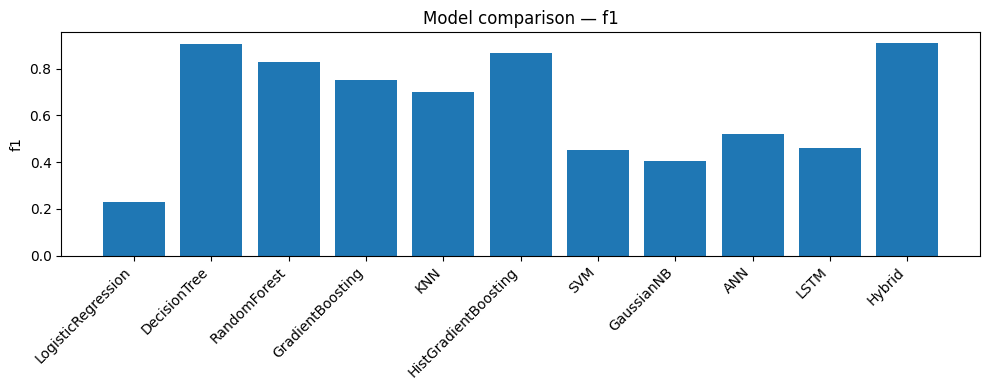

Saved: /content/drive/MyDrive/InfoSec_Dataset/model_outputs/models_accuracy_comparison.png


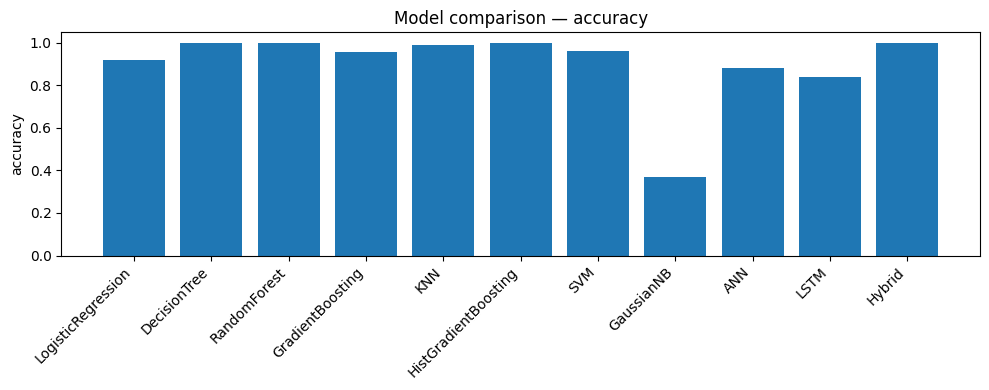

Best model by F1: Hybrid
Saved: /content/drive/MyDrive/InfoSec_Dataset/model_outputs/confusion_Hybrid.png


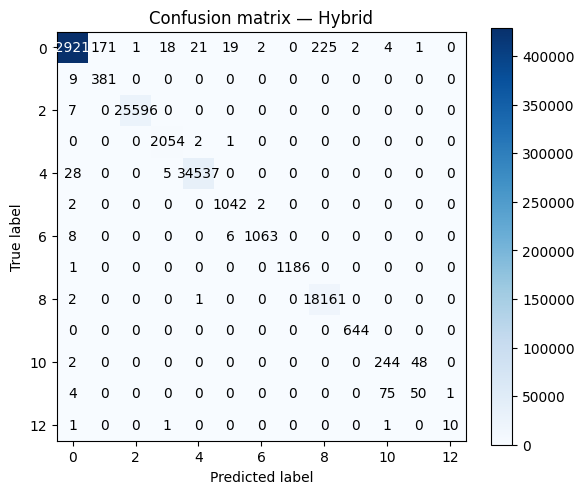

Saved report markdown and displayed all plots.

=== GROUP 4 (Blocks G–I) COMPLETED SUCCESSFULLY ===


In [24]:
# -------------------------
# BLOCK I: Final summary, plots, and report export
# -------------------------
print("\n=== BLOCK I: Final summary, plots, and report export ===")

# 1) Aggregate main metrics for all models
summary = {}
for m, vals in results_classical.items():
    try:
        tm = vals.get("test_metrics", {})
        summary[m] = {
            "accuracy": tm.get("accuracy"),
            "f1": tm.get("f1"),
            "roc_auc": tm.get("roc_auc"),
            "mse": tm.get("mse"),
            "mae": tm.get("mae"),
            "train_time_sec": vals.get("train_time_sec")
        }
    except Exception:
        summary[m] = vals

# Save summary JSON
with open(os.path.join(OUT_DIR, "models_summary.json"), "w") as f:
    json.dump(summary, f, indent=2, default=str)

# ---------------------------------------
# 2) Plot + DISPLAY bar charts (F1, Acc)
# ---------------------------------------
metrics_to_plot = ["f1", "accuracy"]
for metric in metrics_to_plot:
    labels = []
    values = []
    for m in summary:
        labels.append(m)
        val = summary[m].get(metric, None)
        values.append(0.0 if val is None else val)

    plt.figure(figsize=(10,4))
    plt.bar(labels, values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f"Model comparison — {metric}")
    plt.tight_layout()

    # SAVE
    save_path = os.path.join(OUT_DIR, f"models_{metric}_comparison.png")
    plt.savefig(save_path)
    print(f"Saved: {save_path}")

    # SHOW INLINE
    plt.show()
    plt.close()

# ---------------------------------------
# 3) Confusion matrix for best model
# ---------------------------------------
best_model = max(summary.keys(), key=lambda k: (summary[k].get("f1") or 0.0))
print("Best model by F1:", best_model)

if best_model in predictions_classical:
    y_pred_best = predictions_classical[best_model]

    try:
        cm = confusion_matrix(y_test, y_pred_best)
    except Exception:
        if len(y_pred_best) == ROB_TEST_SIZE:
            cm = confusion_matrix(y_test_sub, y_pred_best)
        else:
            cm = None

    if cm is not None:
        plt.figure(figsize=(6,5))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion matrix — {best_model}")
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        for (i, j), val in np.ndenumerate(cm):
            plt.text(
                j, i,
                int(val),
                ha='center', va='center',
                color='white' if val > cm.max()/2 else 'black'
            )

        plt.tight_layout()

        cm_path = os.path.join(OUT_DIR, f"confusion_{best_model}.png")
        plt.savefig(cm_path)
        print(f"Saved: {cm_path}")

        # SHOW INLINE
        plt.show()
        plt.close()

# ---------------------------------------
# 4) Markdown report export
# ---------------------------------------
report_lines = []
report_lines.append("# Model Evaluation Report\n")
report_lines.append(f"Generated: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
report_lines.append("## Summary Metrics\n")

for m, v in summary.items():
    report_lines.append(f"### {m}\n")
    report_lines.append(f"- F1 (macro): {v.get('f1')}\n")
    report_lines.append(f"- Accuracy: {v.get('accuracy')}\n")
    report_lines.append(f"- ROC AUC: {v.get('roc_auc')}\n")
    report_lines.append(f"- MSE: {v.get('mse')}\n")
    report_lines.append(f"- MAE: {v.get('mae')}\n")
    report_lines.append(f"- Train time (s): {v.get('train_time_sec')}\n")

report_lines.append("\n## Robustness (summary in robustness_summary.json)\n")
report_lines.append("See robustness_summary.json and per-model JSON files in the model_outputs folder.\n")

report_md = "\n".join(report_lines)
with open(os.path.join(OUT_DIR, "model_report.md"), "w") as f:
    f.write(report_md)

print("Saved report markdown and displayed all plots.")
print("\n=== GROUP 4 (Blocks G–I) COMPLETED SUCCESSFULLY ===")



=== BLOCK J: Full MSE and MAE Listing for All Models ===

=== MSE Values for All Models (Lowest → Highest) ===
RandomForest               MSE = 0.00019533
DecisionTree               MSE = 0.00025818
HistGradientBoosting       MSE = 0.00034970
Hybrid                     MSE = 0.00150980
KNN                        MSE = 0.00159528
SVM                        MSE = 0.00464397
GradientBoosting           MSE = 0.00717168
LogisticRegression         MSE = 0.00907846
ANN                        MSE = 0.01374346
LSTM                       MSE = 0.01748307
GaussianNB                 MSE = 0.09641264


=== MAE Values for All Models (Lowest → Highest) ===
DecisionTree               MAE = 0.00025818
RandomForest               MAE = 0.00053034
HistGradientBoosting       MAE = 0.00177422
KNN                        MAE = 0.00278690
SVM                        MAE = 0.01009513
GradientBoosting           MAE = 0.01126726
Hybrid                     MAE = 0.01206238
LogisticRegression         MAE = 0.018546

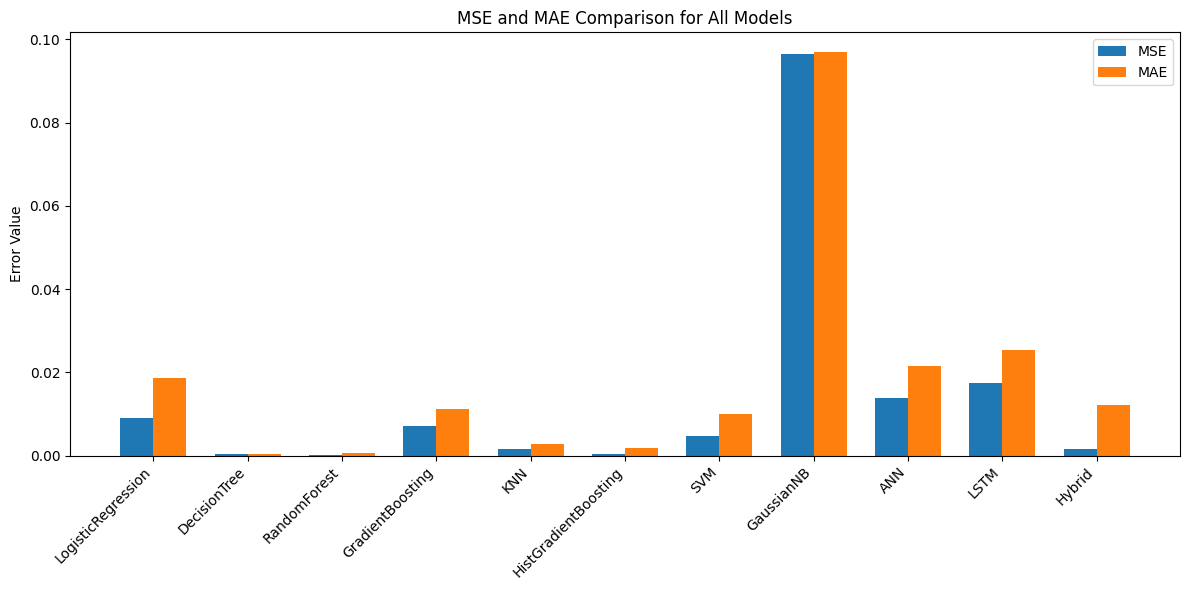


=== Best Models ===
Best MSE Model : RandomForest  (MSE = 0.00019532529748224307)
Best MAE Model : DecisionTree  (MAE = 0.00025817675515744676)

=== BLOCK K Completed Successfully ===


In [27]:
# ============================================================
# BLOCK J: Print all MSE & MAE values for every model
# ============================================================

print("\n=== BLOCK J: Full MSE and MAE Listing for All Models ===")

import pandas as pd

# ---------------------------------------
# Build dataframe from summary
# ---------------------------------------
rows = []
for m, v in summary.items():
    mse = v.get("mse")
    mae = v.get("mae")
    if mse is None or mae is None:
        continue
    rows.append([m, mse, mae])

df_all = pd.DataFrame(rows, columns=["Model", "MSE", "MAE"])

# ---------------------------------------
# Sort by MSE (ascending)
# ---------------------------------------
df_mse_sorted = df_all.sort_values(by="MSE")

print("\n=== MSE Values for All Models (Lowest → Highest) ===")
for _, row in df_mse_sorted.iterrows():
    print(f"{row['Model']:<25}  MSE = {row['MSE']:.8f}")

# ---------------------------------------
# Sort by MAE (ascending)
# ---------------------------------------
df_mae_sorted = df_all.sort_values(by="MAE")

print("\n\n=== MAE Values for All Models (Lowest → Highest) ===")
for _, row in df_mae_sorted.iterrows():
    print(f"{row['Model']:<25}  MAE = {row['MAE']:.8f}")

# ---------------------------------------
# Save a markdown summary for reporting
# ---------------------------------------
md_lines = []
md_lines.append("# Full MSE and MAE Summary\n")

md_lines.append("\n## Sorted by MSE (Best → Worst)\n")
for _, row in df_mse_sorted.iterrows():
    md_lines.append(f"- **{row['Model']}**: MSE = `{row['MSE']}`")

md_lines.append("\n## Sorted by MAE (Best → Worst)\n")
for _, row in df_mae_sorted.iterrows():
    md_lines.append(f"- **{row['Model']}**: MAE = `{row['MAE']}`")

md_text = "\n".join(md_lines)

md_file = os.path.join(OUT_DIR, "mse_mae_summary.md")
with open(md_file, "w") as f:
    f.write(md_text)

print(f"\nSaved full MSE/MAE summary markdown to: {md_file}")

print("\n=== BLOCK J Completed Successfully ===")


# ============================================================
# BLOCK K : Combined MSE + MAE Comparison Per Model
# ============================================================

print("\n=== BLOCK K: Combined MSE + MAE Comparison ===")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------
# 1) Build comparison dataframe
# ---------------------------------------
metrics_list = []

for m, v in summary.items():
    mse = v.get("mse")
    mae = v.get("mae")
    if mse is None or mae is None:
        continue
    metrics_list.append([m, mse, mae])

df_metrics = pd.DataFrame(metrics_list, columns=["Model", "MSE", "MAE"])

# Save CSV
df_path = os.path.join(OUT_DIR, "mse_mae_comparison.csv")
df_metrics.to_csv(df_path, index=False)
print(f"Saved combined MSE/MAE table to: {df_path}")

# ---------------------------------------
# 2) Combined bar chart (two bars per model)
# ---------------------------------------

models = df_metrics["Model"]
x = np.arange(len(models))          # model positions
width = 0.35                        # width of each bar

plt.figure(figsize=(12,6))

plt.bar(x - width/2, df_metrics["MSE"], width, label='MSE')
plt.bar(x + width/2, df_metrics["MAE"], width, label='MAE')

plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel("Error Value")
plt.title("MSE and MAE Comparison for All Models")
plt.legend()
plt.tight_layout()

combined_plot_path = os.path.join(OUT_DIR, "combined_mse_mae_comparison.png")
plt.savefig(combined_plot_path)
print(f"Saved combined MSE/MAE plot to: {combined_plot_path}")

# Show inline
plt.show()
plt.close()

# ---------------------------------------
# 3) Print best MSE/MAE models
# ---------------------------------------
df_sorted_mse = df_metrics.sort_values(by="MSE")
df_sorted_mae = df_metrics.sort_values(by="MAE")

best_mse_model = df_sorted_mse.iloc[0]
best_mae_model = df_sorted_mae.iloc[0]

print("\n=== Best Models ===")
print(f"Best MSE Model : {best_mse_model['Model']}  (MSE = {best_mse_model['MSE']})")
print(f"Best MAE Model : {best_mae_model['Model']}  (MAE = {best_mae_model['MAE']})")

print("\n=== BLOCK K Completed Successfully ===")
